# Leveling The Playing Field

## Overview
We all know that student performances differ every year, but by how much? We explore student performance trends from each year. We discuss findings and make recommendations based on them.

## The Dataset
The dataset consists of student grades broken down by assignments from years 2014 to 2017. Below is a sample of what it looks like.

In [1]:
# Import library(ies)
import pandas as pd

# Read and display raw data
studentData = pd.read_csv("student-data-generator/sampledata.csv")
studentData.head()

,Student ID,Name,Year,Assignment #1,Assignment #2,Assignment #3,Assignment #4,Assignment #5,Assignment #6,Assignment #7,Assignment #8,Assignment #9,Assignment #10
0,100101,Apple Almond,2015,91,95,98,89,89,-1,96,99,97,92
1,102135,Apple Cashew,2016,91,87,97,90,95,97,97,90,95,88
2,103994,Apple Peanut,2014,91,86,90,97,94,87,96,89,96,90
3,104746,Apple Hazelnut,2015,90,99,-1,85,90,95,87,99,95,96
4,105595,Apple Macadamia,2014,97,93,99,-1,98,99,96,-1,91,85


## Initial Processing
Unfortunately, not all assignments have scores. We forgive ungraded assignments by calculating averages based on the ones that do have scores. Unavailable scores are assigned a value of `-1`, and the rest are ranged from `0` to `100`. We calculate the average for each student and place them on a new column.

In [2]:
# Append column with student averages,
# counting available scores

# Utility function for calculate average
def calcAvg(scores):
    n = 0
    tot = 0
    for score in scores:
        # Make sure that score is valid
        if isinstance(score, (float, int)) and score >= 0 and score <= 100:
            n += 1
            tot += score
    
    # If no assignment got turned in, return -1
    return tot / n if n else -1

studentData["Assignment Avg"] = studentData.apply(calcAvg, axis=1)
studentData.head()

,Student ID,Name,Year,Assignment #1,Assignment #2,Assignment #3,Assignment #4,Assignment #5,Assignment #6,Assignment #7,Assignment #8,Assignment #9,Assignment #10,Assignment Avg
0,100101,Apple Almond,2015,91,95,98,89,89,-1,96,99,97,92,94.000000
1,102135,Apple Cashew,2016,91,87,97,90,95,97,97,90,95,88,92.700000
2,103994,Apple Peanut,2014,91,86,90,97,94,87,96,89,96,90,91.600000
3,104746,Apple Hazelnut,2015,90,99,-1,85,90,95,87,99,95,96,92.888889
4,105595,Apple Macadamia,2014,97,93,99,-1,98,99,96,-1,91,85,94.750000


## Trending Average

After getting averages for each student, we collect the average from each year and plot them.

<AxesSubplot:xlabel='Year'>

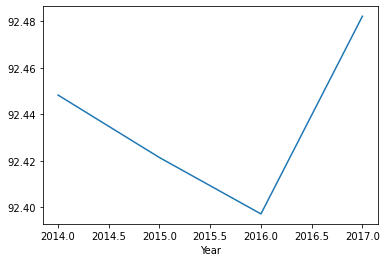

In [13]:
# Group by Year and then average the averages
yearlyAvg = studentData.groupby("Year")["Assignment Avg"].mean()
yearlyAvg.plot.line()